In [100]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "District-wise-contribution_rev.xlsx"
data = pd.read_excel(data_path, skiprows=2, encoding='cp1252')
print(data.head())

                               State                     District  2005-06  \
0                            Column1                      Column2  Column3   
1        Andaman and Nicobar Islands  ANDAMAN AND NICOBAR ISLANDS  258.509   
2  Andaman and Nicobar Islands Total                          NaN  258.509   
3                     Andhra Pradesh                     ADILABAD  1149.47   
4                                NaN                    ANANTAPUR  1692.31   

   2011-12  2014-15 Grand Total  
0  Column4  Column5     Column6  
1   379.21  682.206     439.975  
2   379.21  682.206     439.975  
3  1984.57      NaN     1567.02  
4  3697.94  2838.48     2742.91  


In [3]:
# skipping 1st row in data
data = data.iloc[1:, :]

In [4]:
# Food some missing values in data
# But for state and district we can fill them using ffill technique
data['State'].ffill(inplace = True)

In [5]:
# In district column the NaN spaces are for aggregated values of all 
# the districts in a state, So giving a name should suffice
data['District'].fillna(value = 'ALL_AGG', inplace = True)

In [6]:
# separating cumulative agg records for each state
total = data.loc[data['State'].str.contains('Total'), :].reset_index(drop = True)
data = data.loc[~data['State'].str.contains('Total'), :].reset_index(drop = True)

In [95]:
# State and District are all clear but cropland ecosystem columns 
# still have NaNs
# Let us see the count of NULL values in Each of these 3 columns
print(data.isnull().sum())

State           0
District        0
2005-06        70
2011-12        29
2014-15        11
Grand Total     0
dtype: int64


In [96]:
# Let us see if there are any districts for which all the 3 values are 
# missing, this shouldn't be the case as Total Agg column doesn't have any NaNs
print(data.isnull().all(axis=1).any())

False


Thats good to know that each district has atleast one entry among the  three columns But missing values are yet to be handled Bfill or ffill cannot be used for these columns as the amount per hectare in a district is not dependent on the previous of next district in the given list.

In [106]:
# It makes more sense to compare or process the values with in each 
# state individually rather than considering all the states together

view = data.loc[data['2014-15'].notnull(), :]
view.fillna(value=0, inplace=True)
view['growth_from_06-11'] = (view['2011-12']/view['2005-06'].apply(lambda x : max(x, 1))).values
view['growth_from_12-14'] = (view['2014-15']/view['2011-12'].apply(lambda x : max(x, 1))).values
temp = view.groupby('State')['growth_from_06-11'].agg([np.mean])

No handles with labels found to put in legend.


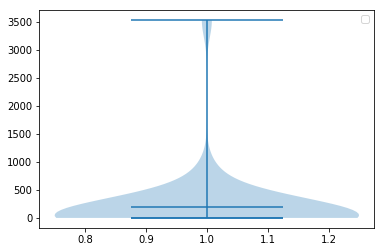

In [107]:
plt.violinplot(temp['mean'], showmeans=True, showextrema=True, showmedians=True)
plt.legend()

In [7]:
# state - district mapping
dis_state_map = {row[1]['District']:row[1]['State'] for row in data.iterrows()}

In [143]:
# Due to the bifurcations of several states same district names are repeated.
# We will try to see the values after eliminating these redundancies
bi_data = data.groupby('District')['2005-06', '2011-12', '2014-15'].sum().reset_index()
bi_data['State'] = [dis_state_map[key] for key in bi_data['District']]
state_agg = bi_data.groupby('State')[['2005-06', '2011-12', '2014-15']].agg([np.sum]).reset_index()
state_agg.columns = ['State', '2005-06', '2011-12', '2014-15']

No handles with labels found to put in legend.


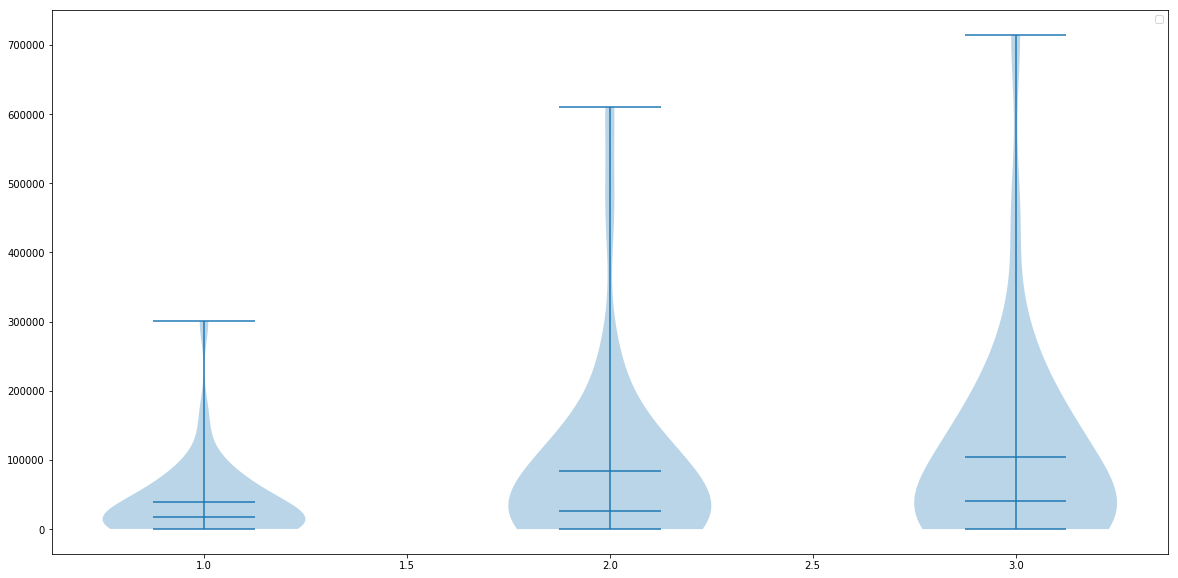

In [154]:
plt.violinplot(state_agg[['2005-06', '2011-12', '2014-15']].T, showmeans=True, showextrema=True, showmedians=True)
plt.legend()
plt.show()

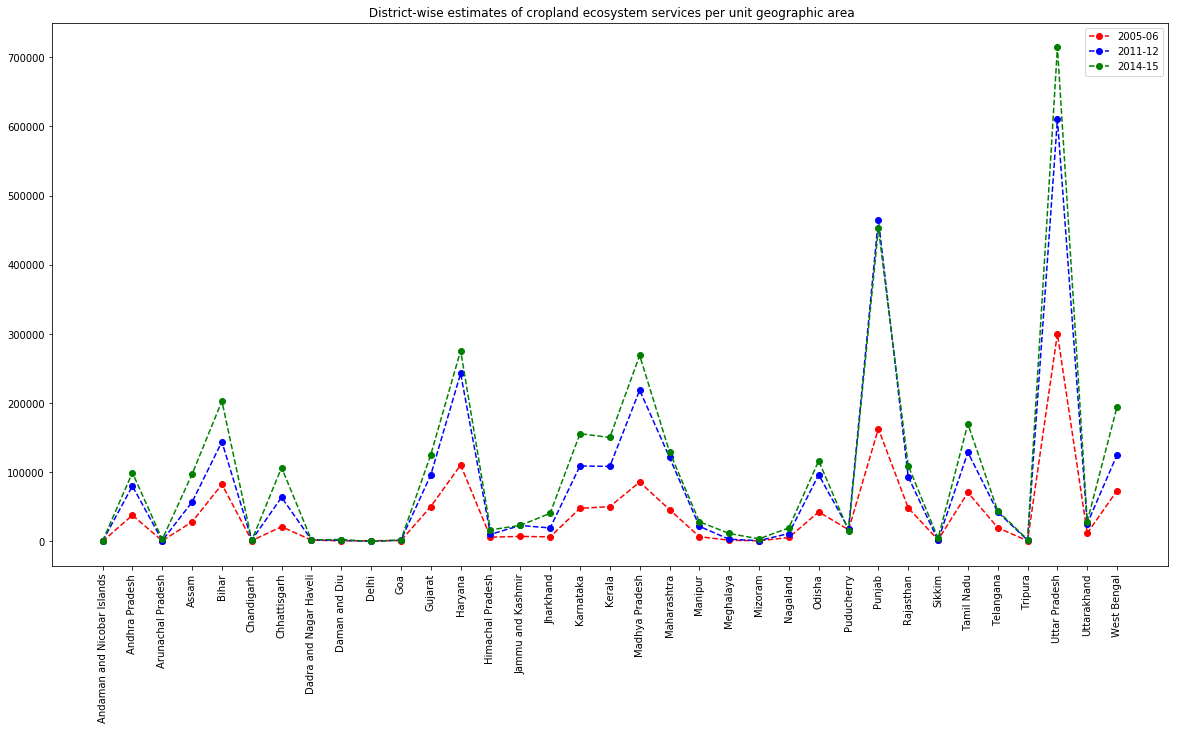

In [147]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(state_agg['State'], state_agg['2005-06'], '--ro')
plt.plot(state_agg['State'], state_agg['2011-12'], '--bo')
plt.plot(state_agg['State'], state_agg['2014-15'], '--go')
plt.title(" District-wise estimates of cropland ecosystem services per unit geographic area")
plt.xticks(state_agg['State'], rotation=90)
plt.legend()
plt.show()